<a href="https://colab.research.google.com/github/Amruth-varsh/Data-Science-Assignment-eCommerce-Transactions-Dataset-/blob/main/Pettem_Amruthvarsh_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['CustomerID', 'total_spent', 'total_quantity', 'avg_transaction_value',
       'transaction_count', 'days_since_signup', 'Region_Europe',
       'Region_North America', 'Region_South America'],
      dtype='object')


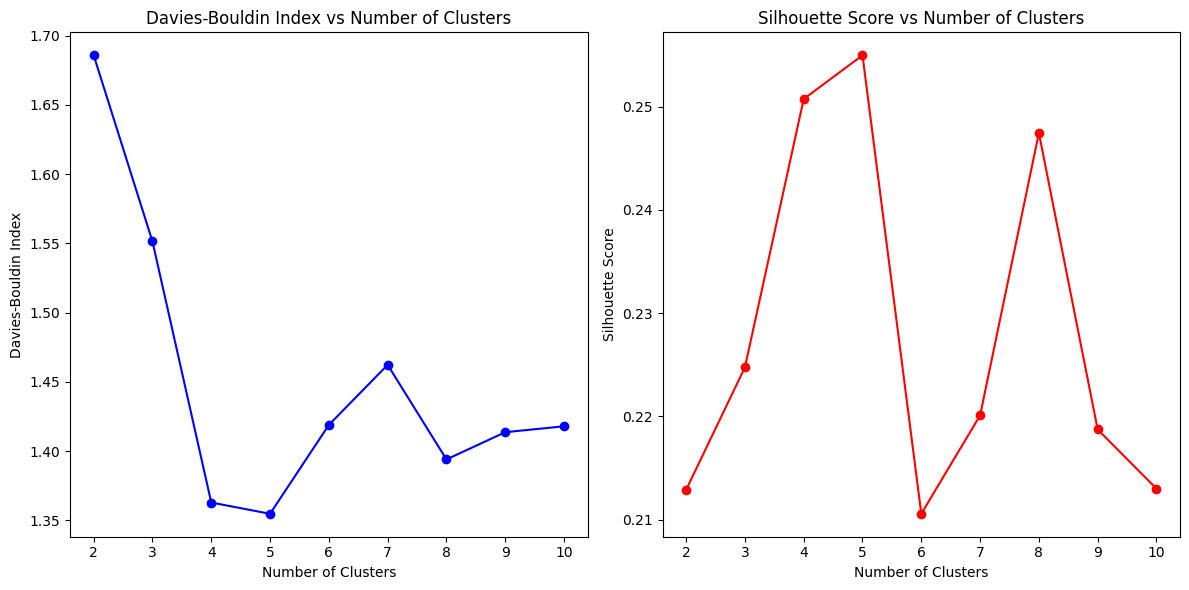

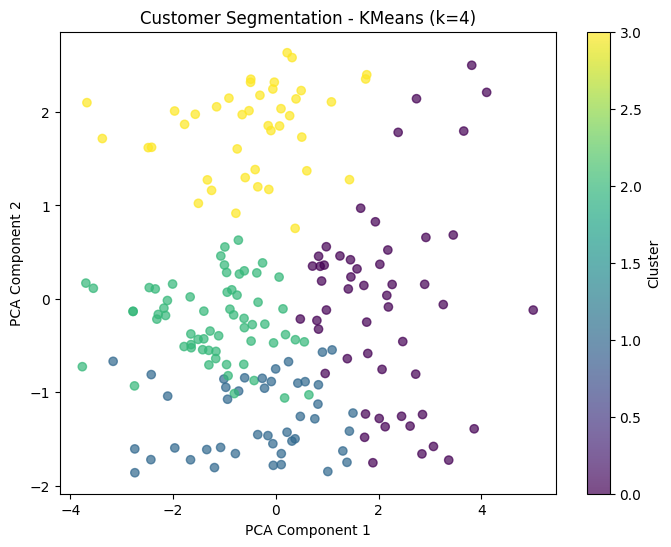

Number of Clusters: 4
Final Davies-Bouldin Index: 1.3628535636007726
Final Silhouette Score: 0.2507531504753906


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Preprocess the data
# Merge the datasets on 'CustomerID'
data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Feature engineering
# 1. Calculate the total value and quantity per customer
customer_data = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count')
).reset_index()

# 2. Extract signup year and days since signup
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['days_since_signup'] = (pd.to_datetime('today') - customers['SignupDate']).dt.days

# Merge the features with customer transaction data
customer_data = pd.merge(customer_data, customers[['CustomerID', 'Region', 'days_since_signup']], on='CustomerID')

# Encoding the 'Region' column
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Inspect the columns in the customer_data DataFrame
print(customer_data.columns)

# Scaling the data
scaler = StandardScaler()

# Drop 'CustomerID' and 'CustomerName' columns only if they exist
columns_to_drop = ['CustomerID', 'CustomerName']
columns_to_drop = [col for col in columns_to_drop if col in customer_data.columns]

# Scale the data (dropping 'CustomerID' and 'CustomerName' if they are present)
scaled_data = scaler.fit_transform(customer_data.drop(columns=columns_to_drop))

# Choosing the number of clusters (between 2 and 10)
db_index_scores = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
    silhouette = silhouette_score(scaled_data, kmeans.labels_)

    db_index_scores.append(db_index)
    silhouette_scores.append(silhouette)

# Visualize DB Index and Silhouette Scores to help select optimal k
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_index_scores, marker='o', color='b', label='DB Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='r', label='Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# After evaluating the scores, we can select the optimal k (let's assume k=4 is optimal)
optimal_k = 4

# Perform K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualizing the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
plt.title(f'Customer Segmentation - KMeans (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Calculate final clustering metrics
db_index_final = davies_bouldin_score(scaled_data, customer_data['Cluster'])
silhouette_final = silhouette_score(scaled_data, customer_data['Cluster'])

print(f"Number of Clusters: {optimal_k}")
print(f"Final Davies-Bouldin Index: {db_index_final}")
print(f"Final Silhouette Score: {silhouette_final}")
